# Jane_Pytorch-LSTM-Implementation 🔥

## References

### EDAs
1. <a href="https://www.kaggle.com/carlmcbrideellis/jane-street-eda-of-day-0-and-feature-importance">Jane Street: EDA of day 0 and feature importance</a>

2. <a href="https://www.kaggle.com/muhammadmelsherbini/jane-street-extensive-eda-pca-starter">
Jane_street_Extensive_EDA & PCA starter 📊⚡</a>

3. <a href="https://www.kaggle.com/hamzashabbirbhatti/eda-a-quant-s-prespective">
EDA / A Quant's Prespective</a>

4. <a href="https://www.kaggle.com/tomwarrens/nan-values-depending-on-time-of-day">NaN values depending on Time of Day</a>

5. <a href="https://www.kaggle.com/sbunzini/reduce-memory-usage-by-75">Reduce Memory Usage by 75%</a>

### Feature Engineering

1. <a href="https://www.kaggle.com/gogo827jz/optimise-speed-of-filling-nan-function">Optimise Speed of Filling-NaN Function</a>

2. <a href="https://www.kaggle.com/apolitano20/jane-street-features-hierarchical-clustering">Features Hierarchical Clustering</a>

3. <a href="https://github.com/GGiecold/pyRMT"> [github] (pyRMT) Randomized Matrix Theory Python Code</a>

4. <a href="https://www.kaggle.com/lucasmorin/running-algos-fe-for-fast-inference">🏃 Running Algos 🏃 FE for fast inference</a>

### Implementing Pytorch-LSTM 🔥

1. <a href="https://www.kaggle.com/omershect/learning-pytorch-lstm-deep-learning-with-m5-data">Learning Pytorch LSTM Deep Learning with M5 Data</a>

2. <a href="https://www.kaggle.com/backtracking/lstm-baseline-pytorch">LSTM-Baseline-Pytorch</a>

## Abstract

This kernel is approach using LSTM via Pytorch. For now when a month left till end of competition, **Most people have focused 'Bottle-Neck AE + MLP with Tuning' Solution for taking 1st place.** Although the situation is like above, **I make a note for LSTM due to my curiosity.**

I have seen some LSTM implements at M5-accurcy competition like my references. And, for adapting it in JaneStreet i read LSTM refs like above. **I really appreciate about their effort what they want to share their experts.**

**In conclusion, first, I have thought this competition is not good for using LSTM.** Because we just get one trade opportunity when we make a prediciton(It's called 'Bottle Neck'). So, There is a problem when we fill null data unlike training data. That's why there is a few rnn and lstm implementations. Even though there is this kind of problem, by stacking last data gradually within sequence length size.

Before doing best solution of this compeition, **I'll do adapt some apporaches for increasing LSTM perfomance as long as I can.** 

**I'll leave comment when I finish to adapt some approaches what I want. :D**

## Comment at 2021-02-01

I commited about Performance Check per Dataset(Origin/Large Hierarchi/Denoise Hierarchi | with rolling data).
Unfortunately, Addional FE datasets are pretty bad perfomance during validation.
So I choose Origin Dataset with mean-filling and 6-sigma Confidence Interval deletion.

I'll share submission result of it later.

And I'll explore Best Solution soon within 1~2days.

I really glad to you guys about reacting my kernel.

**And plz give a upvote to the References what I saw and applied.**

Thanks to you all!!


## Timeline

* **[Day1]** 2021-01-19 

    1. LSTM-pytorch baseline test running for submission (epoch:1; input_dim:130; hidden_dim:256; layer_dim:2)
    2. Filling NaN Values / Handling Outlier
    3. Feature Hierarchical Clustering (Correlation-based distance, Variance of Information, Denoise Large Correlation by Random Matrix Theory)
    
* **[Day2]** 2021-01-20

    1. Filling NaN Values / Handling Outlier
    
* **[Day3]** 2021-01-20

    1. Handling Outlier with **overcoming memory leakage issue**
    2. Application of Hierarchical Clustering Corrleation Distance Method (Non-Denoise, Denoise)
    
* **[Day4]** 2021-01-26

    1. Application of Hierarchical Clustering Corrleation Distance Method (Non-Denoise, Denoise)
    2. Create Squential Dataset
    
* **[Day5]** 2021-01-27

    1. Hierarchical Clustered FE dataset (Large Corr and Denoise Large Corr)  
  
* **[Day6]** 2021-01-28

    1. Creating Additional Features (rolling mean/std per time length)
    2. Create Squence using preprocessed data for LSTM model
    
* **[Day7]** 2021-01-29

    1. Merging processed data
    2. Create pytorch dataset

* **[Day8]** 2021-01-31

    1. Handling Training Speed issue (due to data broadcasting per date of rolling mean and std)
    
* **[Day8]** 2021-02-01

    1. Performance Check per Dataset(Origin/Large Hierarchi/Denoise Hierarchi | with rolling data)
    2. Commenting EDA codes for actual prediction

## Implementation

### Process for Time-Series Data

Image From:

<a href="https://www.kaggle.com/omershect/learning-pytorch-lstm-deep-learning-with-m5-data">
Learning Pytorch LSTM Deep Learning with M5 Data</a>

\- https://www.kaggle.com/omershect/learning-pytorch-lstm-deep-learning-with-m5-data

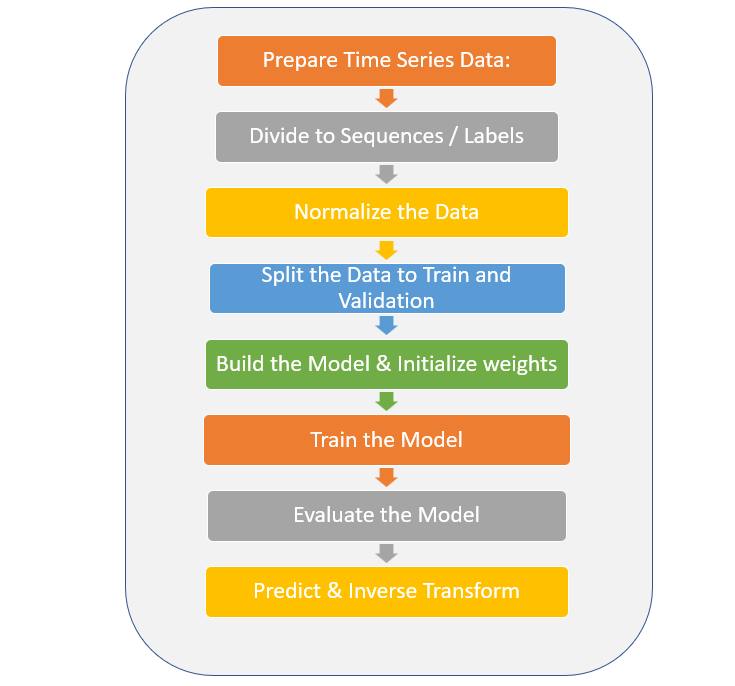

### Import packages and dataset

In [ ]:
import warnings
import os 

from collections import defaultdict
from copy import deepcopy

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
import seaborn as sns

import networkx as nx
import scipy.cluster.hierarchy as sch
from scipy.cluster.hierarchy import fcluster

import random

from tqdm import tqdm_notebook

from sklearn.metrics import roc_auc_score
from sklearn.model_selection import train_test_split

import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from torch.nn import functional as F

# install datatable
!pip install datatable
import datatable as dt

from numba import njit

import gc

warnings.simplefilter(action="ignore")

project_home = "/kaggle/input/jane-street-market-prediction"

### Setting Random seed for prediction

Reference from: 

https://github.com/pytorch/pytorch/issues/7068

In [ ]:
def seed_torch(seed=1029):
    random.seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.cuda.manual_seed_all(seed) # if you are using multi-GPU.
    torch.backends.cudnn.benchmark = False
#     torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.deterministic = False
    
seed_torch()

In [ ]:
train_file = os.path.join(project_home,'train.csv')
features_file = os.path.join(project_home,'features.csv')
example_test_file = os.path.join(project_home,'example_test.csv')
example_sample_submission_file = os.path.join(project_home,'example_sample_submission.csv')

train_data_datatable = dt.fread(train_file)

df_train = train_data_datatable.to_pandas()
df_features = pd.read_csv(features_file)
df_example_test = pd.read_csv(example_test_file)
df_example_sample_submission = pd.read_csv(example_sample_submission_file)

In [ ]:
features = [ col for col in df_train.columns if "feature" in col ]
resps = [ col for col in df_train.columns if "resp" in col ]
target_resp = [resp_ for resp_ in resps if "_" not in resp_]
target = ["weight"] + target_resp + features 

### Reduce Memory Usage

* <a href="https://www.kaggle.com/omershect/learning-pytorch-lstm-deep-learning-with-m5-data">Learning Pytorch LSTM Deep Learning with M5 Data</a>
* <a href="https://www.kaggle.com/sbunzini/reduce-memory-usage-by-75">Reduce Memory Usage by 75%</a>

We need to reduce memory usage because our dataset is too huge.

In [ ]:
df_train.info()

In [ ]:
"""
Reduce Memory Usage by 75%
https://www.kaggle.com/tomwarrens/nan-values-depending-on-time-of-day
"""

## Reduce Memory

def reduce_memory_usage(df):
    
    start_memory = df.memory_usage().sum() / 1024**2
    print(f"Memory usage of dataframe is {start_memory} MB")
    
    for col in df.columns:
        col_type = df[col].dtype
        
        if col_type != 'object':
            c_min = df[col].min()
            c_max = df[col].max()
            
            if str(col_type)[:3] == 'int':
                if c_min > np.iinfo(np.int8).min and c_max < np.iinfo(np.int8).max:
                    df[col] = df[col].astype(np.int8)
                elif c_min > np.iinfo(np.int16).min and c_max < np.iinfo(np.int16).max:
                    df[col] = df[col].astype(np.int16)
                elif c_min > np.iinfo(np.int32).min and c_max < np.iinfo(np.int32).max:
                    df[col] = df[col].astype(np.int32)
                elif c_min > np.iinfo(np.int64).min and c_max < np.iinfo(np.int64).max:
                    df[col] = df[col].astype(np.int64)
            
            else:
#                 reducing float16 for calculating numpy.nanmean
#                 if c_min > np.finfo(np.float16).min and c_max < np.finfo(np.float16).max:
#                     df[col] = df[col].astype(np.float16)
                if c_min > np.finfo(np.float32).min and c_max < np.finfo(np.float32).max:
                    df[col] = df[col].astype(np.float32)
                else:
                    pass
        else:
            df[col] = df[col].astype('category')
    
    end_memory = df.memory_usage().sum() / 1024**2
    print(f"Memory usage of dataframe after reduction {end_memory} MB")
    print(f"Reduced by {100 * (start_memory - end_memory) / start_memory} % ")
    return df

df_train = reduce_memory_usage(df_train)
df_train.info()

### Feature Engineering

1. Filling NaN Values

2. Handling Outlier

3. Clustering using features

4. Creating Additional Features(for time-series data)

#### 1. Filling NaN Values


Before making various features, I'd like to fill null value on out dataset because I couldn't use later method what it will be adapted.

First we need to take a look at null distribution on our dataset for finding some patterns.

The pattern is that null values are occurred at the beginning of trade and mid-time of trade day and it's showed per intra-day pattern like references.

* <a href="https://www.kaggle.com/carlmcbrideellis/jane-street-eda-of-day-0-and-feature-importance">Jane Street: EDA of day 0 and feature importance</a>
* <a href="https://www.kaggle.com/tomwarrens/nan-values-depending-on-time-of-day">NaN values depending on Time of Day</a>




In [ ]:
"""
The codes from 'NaN values depending on Time of Day'
https://www.kaggle.com/tomwarrens/nan-values-depending-on-time-of-day
"""

# def chunks(l, n):
#     """ Yield n successive chunks from l.
#     """
#     newn = int(len(l) / n)
#     for i in range(0, n-1):
#         yield l[i*newn:i*newn+newn]
#     yield l[n*newn-newn:]

In [ ]:
"""
The codes from 'NaN values depending on Time of Day'
https://www.kaggle.com/tomwarrens/nan-values-depending-on-time-of-day
"""

# #count
# nan_values_train = (df_train
#  .apply(lambda x: x.isna().sum(axis = 0)/len(df_train))
#  .to_frame()
#  .rename(columns = {0: 'percentage_nan_values'})
# .sort_values('percentage_nan_values', ascending = False)
# )

# display((df_train
#  .apply(lambda x: x.isna().sum(axis = 0))
#  .to_frame()
#  .rename(columns = {0: 'count_nan_values'})
# .sort_values('count_nan_values', ascending = False)
# .transpose()), nan_values_train.transpose(),
#        print("Number of features with at least one NaN value: {}/{}".format(len(nan_values_train.query('percentage_nan_values>0')),
#                                                                            len(df_train.columns))))

In [ ]:
"""
The codes from 'NaN values depending on Time of Day'
https://www.kaggle.com/tomwarrens/nan-values-depending-on-time-of-day
"""

# fig, ax = plt.subplots(figsize = (20, 12))

# sns.set_palette("RdBu", 10)
# #RdBu, YlGn
# ax = sns.barplot(x='percentage_nan_values', 
#             y='feature', 
#             palette = 'GnBu_r',
#             data=nan_values_train.reset_index().rename(columns = {'index': 'feature'}).head(40))

# for p in ax.patches:
#     width = p.get_width() 
#     if width < 0.01:# get bar length
#         ax.text(width,       # set the text at 1 unit right of the bar
#             p.get_y() + p.get_height() / 2, # get Y coordinate + X coordinate / 2
#             '{:1.4f}'.format(width), # set variable to display, 2 decimals
#             ha = 'left',   # horizontal alignment
#             va = 'center')  # vertical alignment
#     else:
#         if width < 0.04:
#             color_text = 'black'
#         else:
#             color_text = 'white'
#         ax.text(width /2, 
#                 # set the text at 1 unit right of the bar
#             p.get_y() + p.get_height() / 2, # get Y coordinate + X coordinate / 2
#             '{:1.4f}'.format(width), # set variable to display, 2 decimals
#             ha = 'left',   # horizontal alignment
#             va = 'center',
#             color = color_text,
#             fontsize = 10)  # vertical alignment

# ax.set_title('Top 40 Features for percentage of NaN Values')

In [ ]:
"""
The codes from 'NaN values depending on Time of Day'
https://www.kaggle.com/tomwarrens/nan-values-depending-on-time-of-day
"""

# df_plt_train = df_train.copy()
# df_plt_train['daily_ts_id'] = (df_plt_train.groupby('date').cumcount())

# top_nan_features = nan_values_train.head(40).index.tolist() #take the first 40 with most nans
# features_chunks = chunks(top_nan_features, 20)
# mini_df = pd.concat([(df_plt_train[top_nan_features].isna().astype(int)),df_plt_train[['ts_id']]], 1).iloc[:30000, :]
# new_day = (df_plt_train.iloc[:30000, :].query("daily_ts_id == 0").ts_id.tolist())

# df_plt_train = (df_plt_train.set_index('date').join(df_plt_train.groupby('date').size().reset_index().rename(columns = {0: 'daily_number_of_trades'}).set_index('date'))
#         .reset_index())

# df_plt_train['pseudo_time_of_day'] = (df_plt_train['daily_ts_id']/df_plt_train['daily_number_of_trades'])
# gc.collect()

# nan_df = pd.concat([(df_plt_train[top_nan_features].isna().astype(int)), df_plt_train[['pseudo_time_of_day']]], 1)

In [ ]:
"""
The codes from 'NaN values depending on Time of Day'
https://www.kaggle.com/tomwarrens/nan-values-depending-on-time-of-day
"""

# features_chunks = chunks(top_nan_features, 10)
# chunk_len = 4

# for k_chunk in features_chunks:
#     fig, axes = plt.subplots(2, 2, figsize = (40, 30))
#     ax = axes.ravel()
    
#     for i in range(len(k_chunk)):

#         feature_name = k_chunk[i]
#         feature = nan_df.loc[nan_df[feature_name] == 1]['pseudo_time_of_day']
        
#         sns.distplot(feature, hist=True, kde=True, color = 'red', hist_kws={'edgecolor':'black'},
#                      kde_kws={'linewidth': 2, 'color': 'blue'}, ax = ax[i%10])
#         ax[i%10].grid(True)
#         ax[i%10].set(xlabel = 'pseudo_time_of_day')
#         ax[i%10].set_title(feature_name)

As I said via refereces, there are null values on two times per day when beginning and mid-time of days.

It said there is **'pre-order trading'** in some stock market and **'lunch-break'**. It seems reasonable due to as shareholder of stock market in my country.

Then, How we gonna fill NaN value?

There is the way to delete NaN value when we make a prediction. But I don't want to.

So, Let we check some plots for our features.
* Distribution per feature
* Boxplot per feature
* Scatter plot with resp
* Cumsum per featrue

In [ ]:
# df_day_0 = df_train.loc[df_train.date==0]

# features_list = [features[i*30:(i+1)*30]for i in range(5)]
# resp_features = [["resp"]+ features for features in features_list]

# df_resp_features_0 = df_day_0.loc[:, resp_features[0]]

# fig, axes = plt.subplots(30,4,figsize=[28,120])

# for idx, col in enumerate(tqdm_notebook(resp_features[0][1:])):
#     targets = ["resp"] + [col]

#     df_target = df_resp_features_0.loc[:,targets]
#     # 1. distplot
#     sns.distplot(df_target[col], ax=axes[idx,0])
#     # 2. boxplot
#     sns.boxplot(df_target[col], ax=axes[idx,1])
#     # 3. scatterplot with resp
#     sns.regplot(data=df_target, x=col, y="resp", ax=axes[idx,2])
#     # 4. cumulative data
#     df_target[col].cumsum().plot(ax=axes[idx,3])

# plt.suptitle("Overall Distribution per features_0-29 [dist, box, scatter, cumsum]",y=0.89, size=20)

In [ ]:
# df_resp_features_1 = df_day_0.loc[:, resp_features[1]]

# fig, axes = plt.subplots(30,4,figsize=[28,120])

# for idx, col in enumerate(tqdm_notebook(resp_features[1][1:])):
#     targets = ["resp"] + [col]

#     df_target = df_resp_features_1.loc[:,targets]
#     # 1. distplot
#     sns.distplot(df_target[col], ax=axes[idx,0])
#     # 2. boxplot
#     sns.boxplot(df_target[col], ax=axes[idx,1])
#     # 3. scatterplot with resp
#     sns.regplot(data=df_target, x=col, y="resp", ax=axes[idx,2])
#     # 4. cumulative data
#     df_target[col].cumsum().plot(ax=axes[idx,3])

# plt.suptitle("Overall Distribution per features_30-59 [dist, box, scatter, cumsum]",y=0.89, size=20)

In [ ]:
# df_resp_features_2 = df_day_0.loc[:, resp_features[2]]

# fig, axes = plt.subplots(30,4,figsize=[28,120])

# for idx, col in enumerate(tqdm_notebook(resp_features[2][1:])):
#     targets = ["resp"] + [col]

#     df_target = df_resp_features_2.loc[:,targets]
#     # 1. distplot
#     sns.distplot(df_target[col], ax=axes[idx,0])
#     # 2. boxplot
#     sns.boxplot(df_target[col], ax=axes[idx,1])
#     # 3. scatterplot with resp
#     sns.regplot(data=df_target, x=col, y="resp", ax=axes[idx,2])
#     # 4. cumulative data
#     df_target[col].cumsum().plot(ax=axes[idx,3])

# plt.suptitle("Overall Distribution per features_60-89 [dist, box, scatter, cumsum]",y=0.89, size=20)

In [ ]:
# df_resp_features_3 = df_day_0.loc[:, resp_features[3]]

# fig, axes = plt.subplots(30,4,figsize=[28,120])

# for idx, col in enumerate(tqdm_notebook(resp_features[3][1:])):
#     targets = ["resp"] + [col]

#     df_target = df_resp_features_3.loc[:,targets]
#     # 1. distplot
#     sns.distplot(df_target[col], ax=axes[idx,0])
#     # 2. boxplot
#     sns.boxplot(df_target[col], ax=axes[idx,1])
#     # 3. scatterplot with resp
#     sns.regplot(data=df_target, x=col, y="resp", ax=axes[idx,2])
#     # 4. cumulative data
#     df_target[col].cumsum().plot(ax=axes[idx,3])

# plt.suptitle("Overall Distribution per features_90-119 [dist, box, scatter, cumsum]",y=0.89, size=20)

In [ ]:
# df_resp_features_4 = df_day_0.loc[:, resp_features[4]]

# fig, axes = plt.subplots(10,4,figsize=[28,40])

# for idx, col in enumerate(tqdm_notebook(resp_features[4][1:])):
#     targets = ["resp"] + [col]

#     df_target = df_resp_features_4.loc[:,targets]
#     # 1. distplot
#     sns.distplot(df_target[col], ax=axes[idx,0])
#     # 2. boxplot
#     sns.boxplot(df_target[col], ax=axes[idx,1])
#     # 3. scatterplot with resp
#     sns.regplot(data=df_target, x=col, y="resp", ax=axes[idx,2])
#     # 4. cumulative data
#     df_target[col].cumsum().plot(ax=axes[idx,3])

# plt.suptitle("Overall Distribution per features_120-129 [dist, box, scatter, cumsum]",y=0.89, size=20)

I think that most features have **normal distribution**.

The mean method would be nice for fillnas.

When it comes to fill NaN values, howerver, there are **two representative ways** in notebooks of competition.
* **mean**
* **fill-forward**

Then, we need to use **efficient way for filling NaN values** because our dataset is so huge what we are talking about above.

Reference below is nice way to implement it what we want **using numba package**.

<a href="https://www.kaggle.com/gogo827jz/optimise-speed-of-filling-nan-function">Optimise Speed of Filling-NaN Function</a>

**I fill NaN values as mean-based method** because most features have **normal distribution**

In [ ]:
"""
The codes from 'Optimise Speed of Filling-NaN Function'
https://www.kaggle.com/gogo827jz/optimise-speed-of-filling-nan-function
"""

def for_loop(method, matrix, values):
    for i in range(matrix.shape[0]):
        matrix[i] = method(matrix[i], values)
    return matrix

def for_loop_ffill(method, matrix):
    tmp = np.zeros(matrix.shape[1],dtype=np.float32)
    for i in range(matrix.shape[0]):
        matrix[i] = method(matrix[i], tmp)
        tmp = matrix[i]
    return matrix

@njit
def fillna_npwhere_njit(array, values):
    if np.isnan(array.sum()):
        array = np.where(np.isnan(array), values, array)
    return array

In [ ]:
# for estimating how many datas will be deleted by techniques.
date_ts = ["date","ts_id"]
df_date_ts = df_train.loc[:,date_ts]

In [ ]:
# converting numpy for efficient calcualtion.
# ft 1~129
np_train = df_train.loc[:,features[1:]].values
np_train.shape

# ft 0
np_train_ft0 = df_train.loc[:,features[0]].values

In [ ]:
# nead pre-calculate 1.2GB per action
f_mean = np.nanmean(np_train,axis=0)

In [ ]:
print('fillna_npwhere_njit (mean-filling):')
np_mf_train = for_loop(fillna_npwhere_njit, np_train, f_mean)

#### 2. Handling Outliers

Because we fill null values with mean-based way, we could make a line as n percentiles like below plots.

In [ ]:
# fig = plt.figure(figsize=(20,80))
# fig.suptitle('Features Box plot with 0.1% 99.9% whiskers',fontsize=22, y=.89)
# grid =  gridspec.GridSpec(33,4,figure=fig,hspace=.5,wspace=.05)
# counter = 0
# for i in range(33):
#     for j in range(4):
#         if counter > 128:
#             break
            
#         subf = fig.add_subplot(grid[i, j]);
#         sns.boxplot(x= np_mf_train[:, counter],saturation=.5,color= 'blue', ax= subf,width=.5,whis=(.1,99.9));
#         subf.axvline(np_mf_train[:, counter].mean(),color= 'darkorange', label='Mean', linestyle=':',linewidth=3)
#         subf.axvline(np.percentile(np_mf_train[:, counter],97),color= 'chocolate', label='97%', linestyle=':',linewidth=2)
#         subf.axvline(np.percentile(np_mf_train[:, counter],99.5),color= 'darkblue', label='99.5%', linestyle=':',linewidth=2)
#         subf.axvline(np.percentile(np_mf_train[:, counter],.5),color= 'red', label='0.5%', linestyle=':',linewidth=2)
#         subf.legend().set_visible(False)
#         subf.set_xlabel('')
#         subf.set_title('{}'.format(features[counter+1]),fontsize=16)
#         counter += 1
#         gc.collect()

# handles, labels = subf.get_legend_handles_labels()
# fig.legend(handles, labels,ncol=4, bbox_to_anchor=(0.90, 0.893),fontsize=10,
#            title= 'Scale',title_fontsize=14,bbox_transform =fig.transFigure);
# plt.show();

There are many outliers although we set whisker of boxplot between 0.01 and 0.99.

If we delete data with this sense, about 8 % of data is deleted (In EDA).

With same manner of it, I executed to remove those using standard deviation with sigma like handling normal distribution

In [ ]:
sigma = 6

@njit
def drop_sigma(array):
    mean = np.mean(array)
    std = np.std(array)
    low, high = mean - sigma * std, mean + sigma * std
    index = (array > low) & (array < high)
    
    return index

np_index = None

for i in tqdm_notebook(range(np_mf_train.shape[1])):
    target = np_mf_train[:,i]
    index = drop_sigma(target).reshape(-1,1)
    if np_index is None:
        np_index = index
    else:
        np_index = np.concatenate([np_index, index], axis=1)
        
# https://stackoverflow.com/questions/16468717/iterating-over-numpy-matrix-rows-to-apply-a-function-each
np_index = np.apply_along_axis(lambda x: False if False in x else True, axis=1, arr=np_index)

In [ ]:
np_date_ts = df_date_ts.values
np_date_ts = np.concatenate([np_date_ts,np_index.reshape(-1,1)],axis=1)

In [ ]:
def get_numpy_count_sum(array):
    dict_deletion = dict()
    
    max_date = array[:,0].max()+1
    for i in tqdm_notebook(range(max_date)):
        target = array[array[:,0]==i]
        count = target.shape[0]
        non_zero = target[:,2].sum()
        dict_deletion[i] = (count,non_zero, count-non_zero)

    return dict_deletion

dict_deletion = get_numpy_count_sum(np_date_ts)

In [ ]:
dates = dict_deletion.keys()
total = list(map(lambda x: x[0],dict_deletion.values()))
remainder = list(map(lambda x: x[1],dict_deletion.values()))
delete = list(map(lambda x: x[2],dict_deletion.values()))

In [ ]:
fig, ax = plt.subplots(figsize=(15, 5))
total = pd.Series(total, name="total")
remainder = pd.Series(remainder, name="remainder")
delete = pd.Series(delete, name="delete")
ax.set_xlabel ("Date", fontsize=18)
ax.set_title ("Deletion Target via outlier handling", fontsize=18)
total.plot(lw=3)
remainder.plot(lw=3)
delete.plot(lw=3)
plt.legend(loc="upper left");
# del total
del remainder
# del delete
gc.collect();

In [ ]:
print(f"{delete.sum()/total.sum()*100:.4f}%({delete.sum()} among {total.sum()}) of data is deleted by {sigma}-sigma confience interval")

del total
del delete

In [ ]:
np_train = np_mf_train[np_index]
np_train_ft0 = np_train_ft0[np_index]

print(np_train_ft0.shape, np_train.shape)

If I set sigma to 6, **6% of data was deleted.**

In [ ]:
# fig = plt.figure(figsize=(20,80))
# fig.suptitle('[After deleting outlier] Features Box plot with 0.1% 99.9% whiskers',fontsize=22, y=.89)
# grid =  gridspec.GridSpec(33,4,figure=fig,hspace=.5,wspace=.05)
# counter = 0
# for i in range(33):
#     for j in range(4):
#         if counter > 128:
#             break
            
#         subf = fig.add_subplot(grid[i, j]);
#         sns.boxplot(x= np_train[:, counter],saturation=.5,color= 'blue', ax= subf,width=.5,whis=(.1,99.9));
#         subf.axvline(np_train[:, counter].mean(),color= 'darkorange', label='Mean', linestyle=':',linewidth=3)
#         subf.axvline(np.percentile(np_train[:, counter],97),color= 'chocolate', label='97%', linestyle=':',linewidth=2)
#         subf.axvline(np.percentile(np_train[:, counter],99.5),color= 'darkblue', label='99.5%', linestyle=':',linewidth=2)
#         subf.axvline(np.percentile(np_train[:, counter],.5),color= 'red', label='0.5%', linestyle=':',linewidth=2)
#         subf.legend().set_visible(False)
#         subf.set_xlabel('')
#         subf.set_title('{}'.format(features[counter+1]),fontsize=16)
#         counter += 1
#         gc.collect()

# handles, labels = subf.get_legend_handles_labels()
# fig.legend(handles, labels,ncol=4, bbox_to_anchor=(0.90, 0.893),fontsize=10,
#            title= 'Scale',title_fontsize=14,bbox_transform =fig.transFigure);
# plt.show();

#### 3. Clustering

**Reference**

\- <a href="https://www.kaggle.com/apolitano20/jane-street-features-hierarchical-clustering">Features Hierarchical Clustering</a>

https://www.kaggle.com/apolitano20/jane-street-features-hierarchical-clustering

**Additional Context with Reference**

\- Denoising the correlation matrix using 'Random Matrix Theory'

Andrea Politano who is Author of reference above said like this in comment of notebook.

Q. Great work, I think that engineering features using information-theoretic reasoning instead of correlation-based reasoning is better given the noisiness of the data.

A. Agree. **Another possible approach is using random matrix theory to denoise the correlation matrix** (https://arxiv.org/pdf/1610.08104.pdf). It would be interesting indeed to see **what happens to the correlation-based distance when calculated with a denoised correlation matrix.**

**So, I'll gonna denoise the correlation matrix using 'Random Matrix Theory' where it is in github below**

https://github.com/GGiecold/pyRMT

========================================================================================================================

**"All contexts below are from Reference"**

\- <a href="https://www.kaggle.com/apolitano20/jane-street-features-hierarchical-clustering">Features Hierarchical Clustering</a>

https://www.kaggle.com/apolitano20/jane-street-features-hierarchical-clustering

**partial vs hierarchical**

* partitial: produce a flat partition, where an element belongs to one and only one cluster

* hierarchical: create a multi-layered partition, with clusters of elements at the bottom level, clusters of clusters at the next level, and so on, until a single all-inclusive cluster at the top of that hierarchy.

    \- aglomerative(to inclusive side), divisive(to individual side): difference btw direction to make cluster)
    
**Types of cluster models**
 
* Connectivity models: (e.g.: hierarchical clustering) are based on a notion of distance connectivity.

* Centroid models: (e.g.: k-means algorithm) represents each cluster by a single mean vector.

* Distribution models: (e.g.: EM algorithms) clusters are modeled using statistical distributions.

* Density models: (e.g.: DBSCAN, OPTICS) defines clusters as connected dense regions in the data space.

* Graph-based models: (e.g.: HCS clustering algorithm) work by representing the similarity in data through a similarity graph and then finding all the highly connected subgraphs.

Among hierarchical methods, there are two representative choice, 'correlation distance based' and 'Information-based'



In [ ]:
# 1.2GB

weight_resp = ["weight", "resp"]
df_weight_resp = df_train.loc[:, weight_resp]
df_weight_resp.loc[:,"wresp"] = df_weight_resp["weight"].values * df_weight_resp["resp"].values

np_ww_wresp = df_weight_resp.values
np_ww_wresp = np_ww_wresp[np_index,:]

df_weight_resp = df_weight_resp.drop("weight",axis=1)
np_wresp = df_weight_resp.values
np_wresp = np_wresp[np_index,:]

np_wresp.shape

In [ ]:
n_days = 31

n_days_row = [dict_deletion[key][1] for key in list(dict_deletion.keys())[:n_days]]
n_days_row = sum(n_days_row)
n_days_row

# features_{0,...,129}
np_days_ft0 = np_train_ft0[:n_days_row]
np_days_ft = np_train[:n_days_row,:]
np_days_wresp = np_wresp[:n_days_row,:]

In [ ]:
np_days = np.concatenate([np_days_ft0.reshape(-1,1), np_days_ft, np_days_wresp],axis=1)
np_days.shape

In [ ]:
for i in range(np_days.shape[1]):
    np_days[:,i]= ((np_days[:,i] - np.mean(np_days[:,i])) / np.std(np_days[:,i]))

In [ ]:
# print till 5 roews and 10 columns for looking at result
np_days[:5,:10]

##### **Correlation-based distance(w/o denoising)**

**"All contexts below are from Reference"**

\- <a href="https://www.kaggle.com/apolitano20/jane-street-features-hierarchical-clustering">Features Hierarchical Clustering</a>

https://www.kaggle.com/apolitano20/jane-street-features-hierarchical-clustering

Let us analyze the correlation-based metric. Consider the  N×F  feature matrix, where in our case  F=131(w/ resp or wresp)  and  N  is the number of observations. We would like to combine these  F  column vectors into a hierarchical structure of clusters. The steps are as follows:

compute the  F×F  correlation matrix  ρ={ρi,j}i,j=1,...,N 
derive a distance matrix  D=di,j=12(1−ρi,j)−−−−−−−−−√ 
compute the linkage matrix  L  from the distance matrix  D 
rearrange the rows and columns of the correlation matrix so that the largest values lie along the diagonal (Quasi-Diagonalization).
To visualize the distance between features, we will use two very helpful tools: Dendrograms and Minimum Spanning Trees.

It can be shown [2] that  di,j  is a distance in the mathematical sense. If two features are perfectly anticorrelated (ρ=-1), the distance between them is d=1, while if they are perfectly correlated (ρ=1), the distance is d=0.

The distance as a function of the Pearson correlation coefficient is plotted below.

In [ ]:
r = np.linspace(-1,1,500)
d = np.sqrt(0.5*(1-r))

plt.figure(figsize=(12,6))
plt.title('Correlation-based distance')
plt.xlabel('Correlation coefficient')
plt.ylabel('Distance')
plt.plot(r,d)
plt.show()

In [ ]:
ab_features = ["ft_"+feature.split("_")[1] for feature in features]
np_days_ft = ab_features + ["resp", "wresp"]

df_days = pd.DataFrame(np_days, columns = np_days_ft)

corr_mat = df_days.corr()

dist = np.sqrt(0.5*(1-corr_mat))
dist.shape

In [ ]:
fig, (ax1, ax2) = plt.subplots(ncols=2, figsize=(23,9))

sns.heatmap(corr_mat,ax= ax1, cmap='coolwarm');
sns.heatmap(dist,    ax= ax2, cmap='coolwarm');
ax1.title.set_text('Correlation matrix')
ax2.title.set_text('Distance matrix')
plt.show()

In [ ]:
# Complete graph from distance matrix
G = nx.from_numpy_matrix(dist.to_numpy())

labels = dist.columns.values
labels = [s.replace('ft_','') for s in labels]
G = nx.relabel_nodes(G, dict(zip(range(len(labels)), labels)))

In [ ]:
# Minimum spanning tree
T=nx.minimum_spanning_tree(G)

fig = plt.figure(figsize=(20,20))
nx.draw_networkx(T,
                 with_labels=True, 
                 font_size=9, 
                 cmap=plt.cm.coolwarm,
                 pos=nx.kamada_kawai_layout(T),vmin=0, vmax=1)
plt.show()

There are **several LINKAGE ways** define how to cluster features in Hierarchical Clustering

* Average
* Complete
* Single

I Just tried **Average** one for my kernel

In [ ]:
import scipy.cluster.hierarchy as sch
from scipy.cluster.hierarchy import fcluster

# Linkage matrix
link=sch.linkage(dist,'average')

In [ ]:
# Plot dendrogram

fig = plt.figure(figsize=(20, 8))
plt.title('Hierarchical Clustering Dendrogram')
plt.xlabel('Feature')
plt.ylabel('Distance')
plt.hlines(1.65,0,1320)
dn = sch.dendrogram(link,leaf_rotation=90.,leaf_font_size=11.)
plt.show()

In [ ]:
# fcluster forms flat clusters from the hierarchical clustering defined by the given linkage matrix.

max_d = 1.65
lar_clusters = fcluster(link,t=max_d, criterion='distance')

In [ ]:
lar_clusters.shape

In [ ]:
df_lar_clust = pd.DataFrame({'Cluster':lar_clusters, 'Features':np_days_ft})
df_lar_clust.groupby('Cluster').count()

In [ ]:
# Save the cluster-feature in a dictionary 
clust_lar_feat = {}
for k in np.unique(lar_clusters):
    clust_lar_feat[k] = df_lar_clust[df_lar_clust.Cluster == k].Features.values

In [ ]:
clust_lar_feat

In [ ]:
def getQuasiDiag(link):
    # Sort clustered items by distance
    link=link.astype(int)
    sortIx=pd.Series([link[-1,0],link[-1,1]])
    numItems=link[-1,3] # number of original items
    while sortIx.max()>=numItems:
        sortIx.index=range(0,sortIx.shape[0]*2,2) # make space
        df0=sortIx[sortIx>=numItems] # find clusters
        i=df0.index;j=df0.values-numItems
        sortIx[i]=link[j,0] # item 1
        df0=pd.Series(link[j,1],index=i+1)
        sortIx=sortIx.append(df0) # item 2
        sortIx=sortIx.sort_index() # re-sort
        sortIx.index=range(sortIx.shape[0]) # re-index
    return sortIx.tolist()

In [ ]:
sortIx=getQuasiDiag(link)
sortIx=corr_mat.index[sortIx].tolist() # recover labels
corr_diag=corr_mat.loc[sortIx,sortIx] # reorder

sortIx=getQuasiDiag(link)
sortIx=dist.index[sortIx].tolist() # recover labels
dist_diag=dist.loc[sortIx,sortIx] # reorder

In [ ]:
fig, (ax1, ax2) = plt.subplots(ncols=2, figsize=(23,9))

sns.heatmap(corr_diag,ax= ax1, cmap='coolwarm');
sns.heatmap(dist_diag,ax= ax2, cmap='coolwarm');
ax1.title.set_text('Quasi-diagonal Correlation matrix')
ax2.title.set_text('Quasi-diagonal Distance matrix')
plt.show()

[](http://)

##### **Denoising Correlation-based distance by Randmomized Matrix Theory**

**Reference**

<a href="https://github.com/GGiecold/pyRMT"> [github] (pyRMT) Randomized Matrix Theory Python Code</a>

In [ ]:
"""
The codes from '[github] (pyRMT) Randomized Matrix Theory Python Code'
https://github.com/GGiecold/pyRMT
"""


from __future__ import division, print_function
from builtins import reversed
from builtins import map, zip
from collections import MutableSequence, Sequence
import copy
from math import ceil
from numbers import Complex, Integral, Real
import sys
import warnings

import numpy as np
import pandas as pd
from sklearn.covariance import EmpiricalCovariance
from sklearn.preprocessing import StandardScaler

class pyRMT:
    
    def optimalShrinkage(self, X, return_covariance=False, method='rie'):
        """This function computes a cleaned, optimal shrinkage, 
           rotationally-invariant estimator (RIE) of the true correlation 
           matrix C underlying the noisy, in-sample estimate 
           E = 1/T X * transpose(X)
           associated to a design matrix X of shape (T, N) (T measurements 
           and N features).
           One approach to getting a cleaned estimator that predates the
           optimal shrinkage, RIE estimator consists in inverting the 
           Marcenko-Pastur equation so as to replace the eigenvalues
           from the spectrum of E by an estimation of the true ones.
           This approach is known to be numerically-unstable, in addition
           to failing to account for the overlap between the sample eigenvectors
           and the true eigenvectors. How to compute such overlaps was first
           explained by Ledoit and Peche (cf. reference below). Their procedure
           was extended by Bun, Bouchaud and Potters, who also correct
           for a systematic downward bias in small eigenvalues.

           It is this debiased, optimal shrinkage, rotationally-invariant
           estimator that the function at hand implements.

           In addition to above method, this funtion also provides access to:  
           - The finite N regularization of the optimal RIE for small eigenvalues
             as provided in section 8.1 of [3] a.k.a the inverse wishart (IW) regularization.
           - The direct kernel method of O. Ledoit and M. Wolf in their 2017 paper [4]. 
             This is a direct port of their Matlab code.


           Parameters
           ----------
           X: design matrix, of shape (T, N), where T denotes the number
               of samples (think measurements in a time series), while N
               stands for the number of features (think of stock tickers).

           return_covariance: type bool (default: False)
               If set to True, compute the standard deviations of each individual
               feature across observations, clean the underlying matrix
               of pairwise correlations, then re-apply the standard
               deviations and return a cleaned variance-covariance matrix.

           method: type string, optional (default="rie")
               - If "rie" : optimal shrinkage in the manner of Bun & al.
                with no regularisation  
               - If "iw" : optimal shrinkage in the manner of Bun & al.
                with the so called Inverse Wishart regularization
               - If 'kernel': Direct kernel method of Ledoit  Wolf.
           Returns
           -------
           E_RIE: type numpy.ndarray, shape (N, N)
               Cleaned estimator of the true correlation matrix C. A sample
               estimator of C is the empirical covariance matrix E 
               estimated from X. E is corrupted by in-sample noise.
               E_RIE is the optimal shrinkage, rotationally-invariant estimator 
               (RIE) of C computed following the procedure of Joel Bun 
               and colleagues (cf. references below).

               If return_covariance=True, E_clipped corresponds to a cleaned
               variance-covariance matrix.
           References
           ----------
           1 "Eigenvectors of some large sample covariance matrix ensembles",
             O. Ledoit and S. Peche
             Probability Theory and Related Fields, Vol. 151 (1), pp 233-264
           2 "Rotational invariant estimator for general noisy matrices",
             J. Bun, R. Allez, J.-P. Bouchaud and M. Potters
             arXiv: 1502.06736 [cond-mat.stat-mech]
           3 "Cleaning large Correlation Matrices: tools from Random Matrix Theory",
             J. Bun, J.-P. Bouchaud and M. Potters
             arXiv: 1610.08104 [cond-mat.stat-mech]
           4 "Direct Nonlinear Shrinkage Estimation of Large-Dimensional Covariance Matrices (September 2017)", 
             O. Ledoit and M. Wolf https://ssrn.com/abstract=3047302 or http://dx.doi.org/10.2139/ssrn.3047302
        """

        try:
            assert isinstance(return_covariance, bool)
        except AssertionError:
            raise
            sys.exit(1)

        T, N, transpose_flag = self.checkDesignMatrix(X)
        if transpose_flag:
            X = X.T

        if not return_covariance:
            X = StandardScaler(with_mean=False,
                               with_std=True).fit_transform(X)

        ec = EmpiricalCovariance(store_precision=False,
                                 assume_centered=True)
        ec.fit(X)
        E = ec.covariance_

        if return_covariance:
            inverse_std = 1./np.sqrt(np.diag(E))
            E *= inverse_std
            E *= inverse_std.reshape(-1, 1)

        eigvals, eigvecs = np.linalg.eigh(E)
        eigvecs = eigvecs.T

        q = N / float(T)
        lambda_N = eigvals[0]  # The smallest empirical eigenvalue,
                               # given that the function used to compute
                               # the spectrum of a Hermitian or symmetric
                               # matrix - namely np.linalg.eigh - returns
                               # the eigenvalues in ascending order.
        lambda_hats = None

        if method is not 'kernel':
            use_inverse_wishart = (method == 'iw')
            xis = map(lambda x: self.xiHelper(x, q, E), eigvals)
            Gammas = map(lambda x: self.gammaHelper(x, q, N, lambda_N, inverse_wishart=use_inverse_wishart), eigvals)
            xi_hats = map(lambda a, b: a * b if b > 1 else a, xis, Gammas)
            lambda_hats = xi_hats
        else:
             lambda_hats = directKernel(q, T, N, eigvals)

        E_RIE = np.zeros((N, N), dtype=float)
        for lambda_hat, eigvec in zip(lambda_hats, eigvecs):
            eigvec = eigvec.reshape(-1, 1)
            E_RIE += lambda_hat * eigvec.dot(eigvec.T)

        tmp = 1./np.sqrt(np.diag(E_RIE))
        E_RIE *= tmp
        E_RIE *= tmp.reshape(-1, 1)

        if return_covariance:
            std = 1./inverse_std
            E_RIE *= std
            E_RIE *= std.reshape(-1, 1)

        return E_RIE

    def checkDesignMatrix(self, X):
        """
           Parameters
           ----------
           X: a matrix of shape (T, N), where T denotes the number
               of samples and N labels the number of features.
               If T < N, a warning is issued to the user, and the transpose
               of X is considered instead.
           Returns:
           T: type int
           N: type int
           transpose_flag: type bool
               Specify if the design matrix X should be transposed
               in view of having less rows than columns.       
        """

        try:
            assert isinstance(X, (np.ndarray, pd.DataFrame, pd.Series,
                                  MutableSequence, Sequence))
        except AssertionError:
            raise
            sys.exit(1)

        X = np.asarray(X, dtype=float)
        X = np.atleast_2d(X)

        if X.shape[0] < X.shape[1]:
            warnings.warn("The Marcenko-Pastur distribution pertains to "
                          "the empirical covariance matrix of a random matrix X "
                          "of shape (T, N). It is assumed that the number of "
                          "samples T is assumed higher than the number of "
                          "features N. The transpose of the matrix X submitted "
                          "at input will be considered in the cleaning schemes "
                          "for the corresponding correlation matrix.", UserWarning)

            T, N = reversed(X.shape)
            transpose_flag = True
        else:
            T, N = X.shape
            transpose_flag = False

        return T, N, transpose_flag


    def xiHelper(self, x, q, E):
        """Helper function to the rotationally-invariant, optimal shrinkage
           estimator of the true correlation matrix (implemented via function
           optimalShrinkage of the present module). 
           Parameters
           ----------
           x: type derived from numbers.Real
               Would typically be expected to be an eigenvalue from the
               spectrum of correlation matrix E. The present function
               can however handle an arbitrary floating-point number.
           q: type derived from numbers.Real
               The number parametrizing a Marcenko-Pastur spectrum.
           E: type numpy.ndarray
               Symmetric correlation matrix associated with the 
               Marcenko-Pastur parameter q specified above.
           Returns
           -------
           xi: type float
               Cleaned eigenvalue of the true correlation matrix C underlying
               the empirical correlation E (the latter being corrupted 
               with in-sample noise). This cleaned version is computed
               assuming no prior knowledge on the structure of the true
               eigenvectors (thereby leaving the eigenvectors of E unscathed). 
           References
           ----------
           * "Rotational invariant estimator for general noisy matrices",
             J. Bun, R. Allez, J.-P. Bouchaud and M. Potters
             arXiv: 1502.06736 [cond-mat.stat-mech]
           * "Cleaning large Correlation Matrices: tools from Random Matrix Theory",
             J. Bun, J.-P. Bouchaud and M. Potters
             arXiv: 1610.08104 [cond-mat.stat-mech]
        """

        try:
            assert isinstance(x, Real)
            assert isinstance(q, Real)
            assert isinstance(E, np.ndarray) and E.shape[0] == E.shape[1]
            assert np.allclose(E.transpose(1, 0), E)
        except AssertionError:
            raise
            sys.exit(1)

        N = E.shape[0]

        z = x - 1j / np.sqrt(N)
        s = self.stieltjes(z, E)
        xi = x / abs(1 - q + q * z * s)**2

        return xi

    def stieltjes(self, z, E):
        """
           Parameters
           ----------
           z: complex number
           E: square matrix
           Returns
           -------
           A complex number, the resolvent of square matrix E, 
           also known as its Stieltjes transform.
           Reference
           ---------
           "Financial Applications of Random Matrix Theory: a short review",
           J.-P. Bouchaud and M. Potters
           arXiv: 0910.1205 [q-fin.ST]
        """

        try:
            assert isinstance(z, Complex)

            assert isinstance(E, (np.ndarray, pd.DataFrame,
                                  MutableSequence, Sequence))
            E = np.asarray(E, dtype=float)
            E = np.atleast_2d(E)
            assert E.shape[0] == E.shape[1]
        except AssertionError:
            raise
            sys.exit(1)

        N = E.shape[0]

        ret = z * np.eye(N, dtype=float) - E
        ret = np.trace(ret) / N

        return ret

    def gammaHelper(self, x, q, N, lambda_N, inverse_wishart=False):
        """Helper function to optimalShrinkage function defined below.
           The eigenvalue to the cleaned estimator of a true correlation
           matrix are computed via the function xiHelper defined above in
           the module at hand. 

           It is known however that when N is not very large
           a systematic downward bias affects the xiHelper estimator for small
           eigenvalues of the noisy empirical correlation matrix. This bias
           can be heuristically corrected by computing
           xi_hat = xi_RIE * max(1, Gamma),
           with Gamma evaluated by the function gammaHelper herewith.
           Parameters
           ----------
           x: type float or any other type derived from numbers.Real
               Typically an eigenvalue from the spectrum of a sample
               estimate of the correlation matrix associated to some
               design matrix X. However, the present function supports
               any arbitrary floating-point number x at input.
           q: type derived from numbers.Real
               Parametrizes a Marcenko-Pastur spectrum.
           N: type derived from numbers.Integral
               Dimension of a correlation matrix whose debiased, 
               rotationally-invariant estimator is to be assessed via
               the function RIE (see below), of which the present function
               is a helper.
           lambda_N: type derived from numbers.Real
               Smallest eigenvalue from the spectrum of an empirical
               estimate to a correlation matrix.

           inverse_wishart: type bool default: False
                Wether to use inverse wishart regularization
           Returns
           ------
           Gamma: type float
               Upward correction factor for computing a debiased 
               rotationally-invariant estimator of a true underlying 
               correlation matrix. 
           Reference
           ---------
           "Cleaning large Correlation Matrices: tools from Random Matrix Theory",
            J. Bun, J.-P. Bouchaud and M. Potters
            arXiv: 1610.08104 [cond-mat.stat-mech]
        """

        try:
            assert isinstance(x, Real)
            assert isinstance(q, Real)
            assert isinstance(N, Integral)
            assert isinstance(lambda_N, Real)
        except AssertionError:
            raise
            sys.exit(1)

        z = x - 1j / np.sqrt(N)

        lambda_plus = (1 + np.sqrt(q))**2
        lambda_plus /= (1 - np.sqrt(q))**2
        lambda_plus *= lambda_N
        sigma_2 = lambda_N / (1 - np.sqrt(q))**2

        # gmp defined below stands for the Stieltjes transform of the
        # rescaled Marcenko-Pastur density, evaluated at z
        gmp = z + sigma_2 * (q - 1) - np.sqrt((z - lambda_N) * (z - lambda_plus))
        gmp /= 2 * q * sigma_2 * z

        Gamma = abs(1 - q + q * z * gmp)**2
        Gamma *= sigma_2

        if inverse_wishart:
            kappa = 2 * lambda_N / ((1 - q - lambda_N) ** 2 - 4 * q * lambda_N)
            alpha_s = 1 / (1 + 2 * q * kappa)
            denom = x / (1 + alpha_s * (x - 1.))
            Gamma /= denom
        else: 
            Gamma /= x

        return Gamma


In [ ]:
rmt = pyRMT()
corr_mat = rmt.optimalShrinkage(df_days)

In [ ]:
corr_mat = pd.DataFrame(corr_mat, columns=np_days_ft)
dist = np.sqrt(0.5*(1-corr_mat))

In [ ]:
dist = dist.fillna(0)

In [ ]:
fig, (ax1, ax2) = plt.subplots(ncols=2, figsize=(23,9))

sns.heatmap(corr_mat,ax= ax1, cmap='coolwarm');
sns.heatmap(dist,    ax= ax2, cmap='coolwarm');
ax1.title.set_text('Correlation matrix')
ax2.title.set_text('Distance matrix')
plt.show()

In [ ]:
import networkx as nx
import scipy.cluster.hierarchy as sch
from scipy.cluster.hierarchy import fcluster

# Complete graph from distance matrix
G = nx.from_numpy_matrix(dist.to_numpy())

labels = dist.columns.values
labels = [s.replace('ft_','') for s in labels]
G = nx.relabel_nodes(G, dict(zip(range(len(labels)), labels)))

In [ ]:
# Minimum spanning tree
T=nx.minimum_spanning_tree(G)

fig = plt.figure(figsize=(20,20))
nx.draw_networkx(T,
                 with_labels=True, 
                 font_size=9, 
                 cmap=plt.cm.coolwarm,
                 pos=nx.kamada_kawai_layout(T),vmin=0, vmax=1)
plt.show()

In [ ]:
# Linkage matrix
link=sch.linkage(dist,'average')
# link2=sch.linkage(dist,'complete')

In [ ]:
# Plot dendrogram

fig = plt.figure(figsize=(20, 8))
plt.title('Hierarchical Clustering Dendrogram')
plt.xlabel('Feature')
plt.ylabel('Distance')
plt.hlines(1.37,0,1320)
dn = sch.dendrogram(link,leaf_rotation=90.,leaf_font_size=11.)
plt.show()

In [ ]:
# fcluster forms flat clusters from the hierarchical clustering defined by the given linkage matrix.

max_d = 1.37
den_clusters = fcluster(link,t=max_d, criterion='distance')

In [ ]:
df_den_clust = pd.DataFrame({'Cluster':den_clusters, 'Features':np_days_ft})
df_den_clust.groupby('Cluster').count()

In [ ]:
# Save the cluster-feature in a dictionary 
clust_den_feat = {}
for k in np.unique(den_clusters):
    clust_den_feat[k] = df_den_clust[df_den_clust.Cluster == k].Features.values

In [ ]:
for k in np.unique(den_clusters):
    print('Cluster_{}'.format(k,2),'->', df_den_clust[df_den_clust.Cluster == k].Features.values)

Spliting Dataset for Empirical Comparison 
* Origin
* Large Corr Hierarchical Cluster
* Denoised Corr Hierarchical Cluster 

In [ ]:
# origin
np_train = np.concatenate([np_train_ft0.reshape(-1,1), np_train],axis=1)
np_train.shape

In [ ]:
clust_den_feat

In [ ]:
# delete wresp and resp for lar/den cluster 
clust_lar_feat = {key: np.array([int(value.split("_")[1]) for value in values[np.where(~((values == "resp") | (values == "wresp")))]]) for key, values in clust_lar_feat.items()}
clust_den_feat = {key: np.array([int(value.split("_")[1]) for value in values[np.where(~((values == "resp") | (values == "wresp")))]]) for key, values in clust_den_feat.items()}

In [ ]:
def cluster_feature(dict_clust, array):
    result = None
    for key, values in dict_clust.items():
        mid_result = np.ones(array.shape[0]).reshape(-1,1)
        for col in values:
            mid_result *= array[:,col].reshape(-1,1)
        
        if result is None:
            result = mid_result
        else:
            result = np.concatenate([result,mid_result],axis=1)
        
            
    return result

In [ ]:
np_lar_train = cluster_feature(clust_lar_feat, np_train)
np_den_train = cluster_feature(clust_den_feat, np_train)

In [ ]:
# date numpy array after outlier deletion (for rolling feature)
date = np_date_ts[np.where(np_date_ts[:,2] == 1)][:,0]

#### 4. Creating Additional Features (for time-series data)

Now, It's time to create Additional Feature for Time- series by using data cleaned by Null value Imputation, Removing Outliers, and Clustering.

Before Creating Additional Features, Scaling Dataset first.

In [ ]:
from sklearn.preprocessing import MinMaxScaler

scaler = MinMaxScaler()
lar_scaler = MinMaxScaler()
den_scaler = MinMaxScaler()

In [ ]:
np_train = scaler.fit_transform(np_train)
np_lar_train = lar_scaler.fit_transform(np_lar_train)
np_den_train = den_scaler.fit_transform(np_den_train)

In [ ]:
np_date_drop = np_date_ts[np_index]
np_date_drop.shape

In [ ]:
# 하나의 datapoint(row)에서 0인 값을 가지는 index
np_lar_index = np.apply_along_axis(lambda x: x==0, axis=1, arr=np_lar_train).sum(axis=1) == True
np_den_index = np.apply_along_axis(lambda x: x==0, axis=1, arr=np_den_train).sum(axis=1) == True

In [ ]:
np.where(np_lar_index == True)

In [ ]:
np.where(np_den_index == True)

Among the way creating additional feature, I just tried rolling average and std per specific time sequence.
**(I'll add various one later like reference's way)**

* Rolling Average - moving_avg_per_date (like pandas.Series.rolling.mean())
* Rolling Std - moving_std_per_date (like pandas.Series.rolling.std())

Images from:

<a href="https://www.kaggle.com/omershect/learning-pytorch-lstm-deep-learning-with-m5-data">
Learning Pytorch LSTM Deep Learning with M5 Data</a>

\- https://www.kaggle.com/omershect/learning-pytorch-lstm-deep-learning-with-m5-data


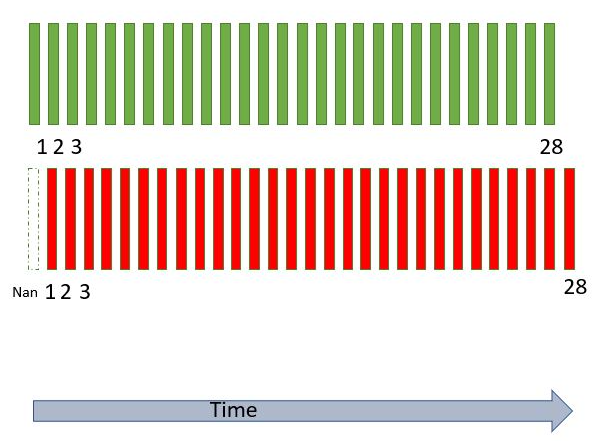

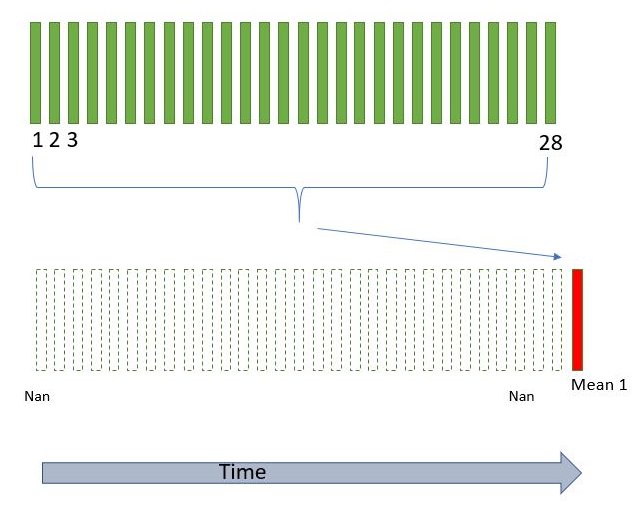

In [ ]:
from collections import deque

def moving_avg_per_date(array, date_array, num_date=500, seq_len=5):
    dict_result = dict()
    window = deque(maxlen=seq_len+1)

    for date in range(500):
        if date < seq_len:
            result = np.zeros(array.shape[1])
            dict_result[date] = result

            stacking = np.mean(array[np.where(date_array[:,0] == date)],axis=0) 
            window.append(stacking)

        else:
            window.popleft()
            stacking = np.mean(array[np.where(date_array[:,0] == date)],axis=0) 
            window.append(stacking)

            dict_result[date] = np.mean(window,axis=0)
            
    return dict_result

def moving_std_per_date(array, date_array, num_date=500, seq_len=5):
    dict_result = dict()
    window = deque(maxlen=seq_len+1)

    for date in range(500):
        if date < seq_len:
            result = np.zeros(array.shape[1])
            dict_result[date] = result

            stacking = np.std(array[np.where(date_array[:,0] == date)],axis=0) 
            window.append(stacking)

        else:
            window.popleft()
            stacking = np.std(array[np.where(date_array[:,0] == date)],axis=0) 
            window.append(stacking)

            dict_result[date] = np.mean(window,axis=0)
            
    return dict_result

In [ ]:
seq_len = 5
dict_mov_avg = moving_avg_per_date(np_train, np_date_drop, seq_len = seq_len)
dict_mov_std = moving_std_per_date(np_train, np_date_drop, seq_len = seq_len)

In [ ]:
# lar / den corrleation rolling feature

# seq_len = 5
# dict_lar_mov_avg = moving_avg_per_date(np_lar_train, np_date_drop, seq_len = seq_len)
# dict_lar_mov_std = moving_std_per_date(np_lar_train, np_date_drop, seq_len = seq_len)

# dict_lar_mov_avg = moving_avg_per_date(np_lar_train, np_date_drop, seq_len = seq_len)
# dict_lar_mov_std = moving_std_per_date(np_lar_train, np_date_drop, seq_len = seq_len)

Using datatable is too slow during training process, Although dt(datatable) was efficient for merging data without any memory leakage issue.

In [ ]:
# df_date = pd.DataFrame(np_date_drop[:,0],columns=["date"])

# df_train = pd.DataFrame(np_train, columns = features)
# df_train = pd.concat([df_date,df_train],axis=1)

# df_mov_avg = pd.DataFrame.from_dict(dict_date_mov_avg).transpose()
# df_mov_avg.columns = [feature+f"_{seq_len}_avg" for feature in features]
# df_mov_std = pd.DataFrame.from_dict(dict_date_mov_std).transpose()
# df_mov_std.columns = [feature+f"_{seq_len}_std" for feature in features]

# df_mov = pd.concat([df_mov_avg, df_mov_std], axis=1)

# columns = df_mov.columns.to_list()
# df_mov = df_mov.reset_index()
# df_mov.columns = ["date"] + columns

# dt_train = dt.Frame(df_train)
# dt_mov = dt.Frame(df_mov)

# dt_mov.key = "date"

# dt_train = dt_train[:,:,dt.join(dt_mov)]

# dt_ww_wresp = dt.Frame(np_ww_wresp,names=["weight","resp","wresp"])
# dt_train = dt.cbind([dt_train,dt_ww_wresp])

### Prediction

#### Results of FEs

I get results in empirical way. it seems imgs below.

**So, I decided apply Origin data without FE method**

Parameter
    * batch_size = 4096
    * learning_rate = 0.01
    * epochs = 10
    * seq_len = 31
    * hidden_dim = 256
    * layer_dim = 2
    * output_dim = 1

* Origin

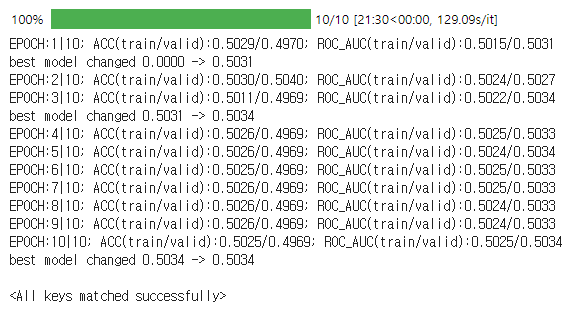

* Origin_with_Rolling

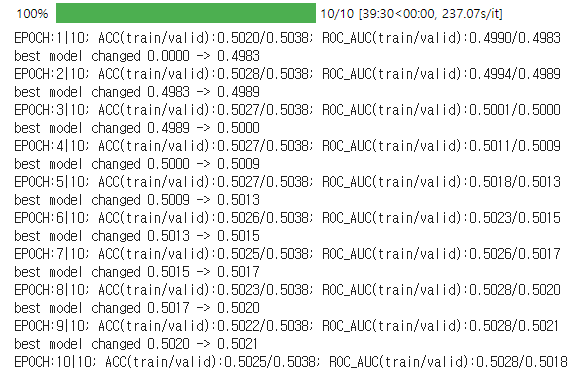

* Lar

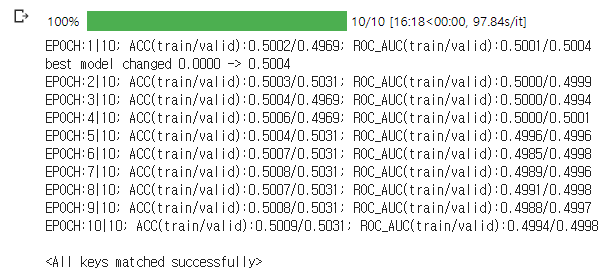

* Lar_rolling

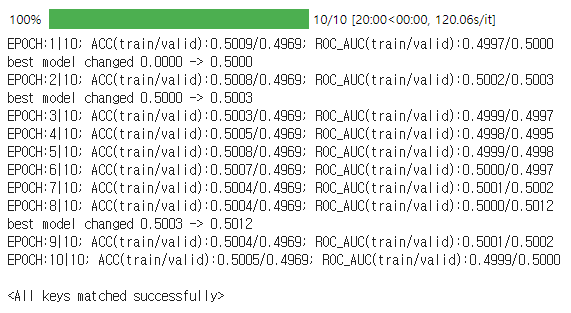

* Den

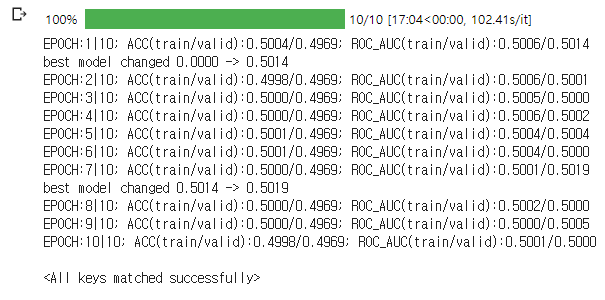

* Den_rolling

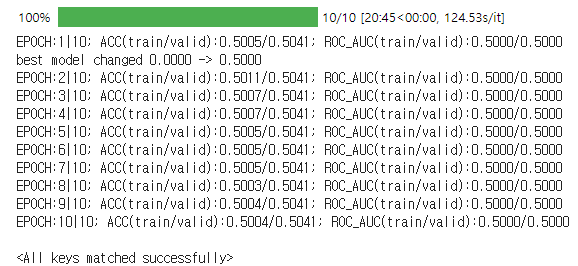

#### Create Dataset by Time-wise seqeunce for LSTM

Image from:

<a href="https://colah.github.io/posts/2015-08-Understanding-LSTMs/">Understanding LSTM Networks</a>

\- https://colah.github.io/posts/2015-08-Understanding-LSTMs/

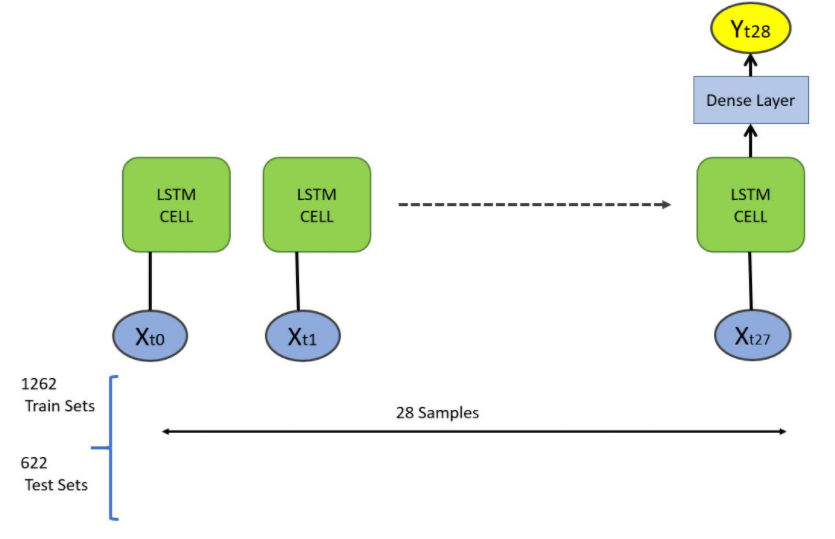

We need to make 'Sequence' for training LSTM Model above. In above image, the Xt0 .. Xt27 means a fragment per sequence. So we gather Xt0...Xt27 to XT0 as simliar single row common dataset. The process to make dataset seems like below image per time sequence(len). By gathering by XT0...XT(N-28-1[due to number begins from 0]), we could train LSTM model like ordinary point-wise ML model.

Image from:

<a href="https://www.kaggle.com/omershect/learning-pytorch-lstm-deep-learning-with-m5-data">
Learning Pytorch LSTM Deep Learning with M5 Data</a>

\- https://www.kaggle.com/omershect/learning-pytorch-lstm-deep-learning-with-m5-data

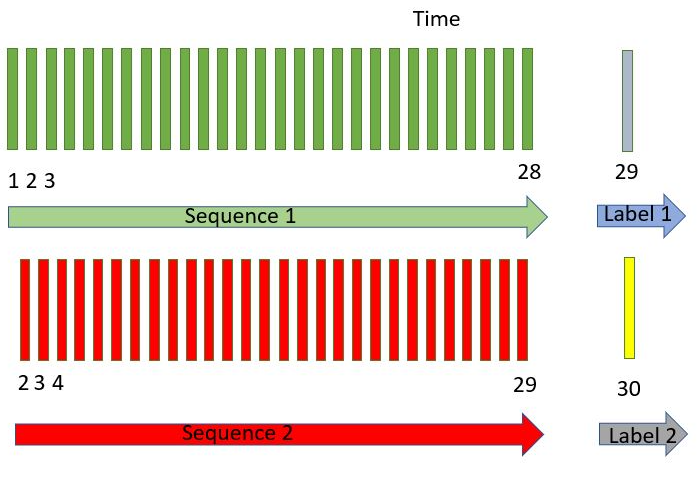

Using datatable is too slow during training process, Although dt(datatable) was efficient for merging data without any memory leakage issue.

In [ ]:
# device = "cuda:0" if torch.cuda.is_available() else "cpu"

# # features + weight
# X = dt_train[:,1:-2]
# y = dt_train[:,"resp"].to_pandas()["resp"].apply(lambda x: 1 if x > 0 else 0)

# scaled_weight = scaler.fit_transform(X[:,"weight"].to_pandas())
# X[:,"weight"] = scaled_weight

# class TimeSeries_Dataset(Dataset):
#     def __init__(self,X,y,seq_len=28):
#         super(TimeSeries_Dataset,self).__init__()
#         self.X = X
#         self.y = y
#         self.seq_len = seq_len
        
#     def __len__(self):
#         return self.X.shape[0] - (self.seq_len) 
        
        
#     def __getitem__(self,index):
#         X = torch.tensor(self.X[index:index+self.seq_len,:].to_numpy(), dtype=torch.float)
#         y = torch.tensor(self.y[index+self.seq_len], dtype=torch.float)
#         return X,y

Additional Dataset spends about 11mins for training 1epoch

The main reason of low performance is concatenating process in Pytorch Dataset. 

The reason was **broadcasting of daily dictionary to Dataset**

In [ ]:
# date for dictionary
# np_dates = np_date_drop[:,0]
# np_action = np.array(list(map(lambda x: 1 if x > 0 else 0,np_ww_wresp[:,1])))

In [ ]:
# X = np_lar_train
# y = np.array(list(map(lambda x: 1 if x > 0 else 0 ,np_ww_wresp[:,1])))

In [ ]:
# class TimeSeries_Dataset(Dataset):
#     def __init__(self,dates,X,dict_avg,dict_std,y,seq_len=28):
#         super(TimeSeries_Dataset,self).__init__()
#         self.dates = dates
#         self.X = X
#         self.y = y
#         self.dict_avg = dict_avg
#         self.dict_std = dict_std
#         self.seq_len = seq_len
        
#     def __len__(self):
#         return self.X.shape[0] - (self.seq_len) 
        
        
#     def __getitem__(self,index):
#         date = self.dates[index]
#         X = self.X[index:index+self.seq_len,:]
#         # Main reason of low performance
#         np_avg = np.array(list(map(lambda x: self.dict_avg[x],self.dates[:self.seq_len])))
#         np_std = np.array(list(map(lambda x: self.dict_std[x],self.dates[:self.seq_len])))
        
#         X = torch.tensor(np.concatenate([X, np_avg, np_std], axis=1),dtype=torch.float) 
#         y = torch.tensor(self.y[index+self.seq_len], dtype=torch.float)
#         return X,y

In [ ]:
# train_dataset = TimeSeries_Dataset(np_dates, X, dict_mov_avg, dict_mov_std, y,seq_len=31)

Enhancing Performance for this Dataset

In [ ]:
# np_mov_avg = np.array(list(map(lambda x: dict_lar_mov_avg[x],np_dates)))
# np_mov_std = np.array(list(map(lambda x: dict_lar_mov_std[x],np_dates)))

In [ ]:
# class TimeSeries_Dataset(Dataset):
#     def __init__(self,X,X_avg,X_std,y,seq_len=28):
#         super(TimeSeries_Dataset,self).__init__()
#         self.X = X
#         self.y = y
#         self.X_avg = X_avg
#         self.X_std = X_std
#         self.seq_len = seq_len
        
#     def __len__(self):
#         return self.X.shape[0] - (self.seq_len) 
        
        
#     def __getitem__(self,index):
#         X = self.X[index:index+self.seq_len,:]
#         np_avg = self.X_avg[index:index+self.seq_len,:]
#         np_std = self.X_std[index:index+self.seq_len,:]
        
#         X = torch.tensor(np.concatenate([X, np_avg, np_std], axis=1),dtype=torch.float) 
#         y = torch.tensor(self.y[index+self.seq_len], dtype=torch.float)
#         return X,y

In [ ]:
# train_dataset = TimeSeries_Dataset(X, np_mov_avg, np_mov_std, y,seq_len=31)

Origin Dataset spends about 2mins for training 1epoch

In [ ]:
X = np_train
y = np.array(list(map(lambda x: 1 if x > 0 else 0 ,np_ww_wresp[:,1])))

In [ ]:
class TimeSeries_Dataset(Dataset):
    def __init__(self,X,y,seq_len=28):
        super(TimeSeries_Dataset,self).__init__()
        self.X = X
        self.y = y
        self.seq_len = seq_len
        
    def __len__(self):
        return self.X.shape[0] - (self.seq_len) 
        
        
    def __getitem__(self,index):
        X = torch.tensor(self.X[index:index+self.seq_len,:], dtype=torch.float)
        y = torch.tensor(self.y[index+self.seq_len], dtype=torch.float)
        return X,y

In [ ]:
train_dataset = TimeSeries_Dataset(X,y,seq_len=31)

In [ ]:
class LSTM(nn.Module):
    def __init__(self, input_dim, hidden_dim, layer_dim, output_dim):
        super(LSTM,self).__init__()
        self.hidden_dim = hidden_dim
        self.layer_dim = layer_dim
        self.lstm = nn.LSTM(input_dim, hidden_dim, layer_dim, batch_first=True)
        # self.fc = nn.Linear(hidden_dim,output_dim)
        
        # take sigmoid for Classification
        self.fc = nn.Sequential(
                      nn.Linear(hidden_dim,output_dim),
                      nn.Sigmoid()
                    )
        
    def forward(self, x):
        h0,c0 = self.init_state(x)
        output, (h_n, c_n) = self.lstm(x,(h0,c0))
        out = self.fc(output[:,-1,:])
        return out
        
    def init_state(self, x):
        h0 = torch.zeros(self.layer_dim, x.size(0), self.hidden_dim).to(device)
        c0 = torch.zeros(self.layer_dim, x.size(0), self.hidden_dim).to(device)
        return h0, c0

In [ ]:
batch_size = 4096
learning_rate = 0.01
epochs = 10

seq_len = 31
input_dim = train_dataset[0][0].shape[1]
hidden_dim = 256
layer_dim = 2
output_dim = 1

model = LSTM(input_dim, hidden_dim, layer_dim, output_dim)
criterion = nn.BCELoss()
optimizer = optim.Adam(model.parameters(),lr=learning_rate)

In [ ]:
train_size = int(len(train_dataset) * 0.8)
valid_size = len(train_dataset) - train_size

In [ ]:
train_dataset, valid_dataset= torch.utils.data.random_split(train_dataset, [train_size, valid_size], generator=torch.Generator().manual_seed(1029))

In [ ]:
train_dataloader = DataLoader(train_dataset, batch_size=batch_size, shuffle=False) 
valid_dataloader = DataLoader(valid_dataset, batch_size=batch_size, shuffle=False)

In [ ]:
device = "cuda:0" if torch.cuda.is_available() else "cpu"

In [ ]:
train_score = defaultdict(list)
valid_score = defaultdict(list)

model = model.to(device)
best_auc = 0

IS_CONTIN = False

file_name = f"LSTM_{input_dim}_{hidden_dim}_{layer_dim}.pth"
model_file_path = os.path.join(project_home, file_name)

if ~IS_CONTIN:
    if os.path.isfile(model_file_path):
        os.remove(model_file_path)
else:
    model.load_state_dict(torch.load(model_file_path))

for epoch in tqdm_notebook(range(epochs)):

    train_acc = 0
    train_auc = 0

    valid_acc = 0
    valid_auc = 0

    for idx, (inputs, label) in enumerate(train_dataloader):
        model.train()
        optimizer.zero_grad()

        inputs = inputs.to(device)
        label = label.to(device).unsqueeze(1)
        
        outputs = model(inputs)
        loss = criterion(outputs,label)
        loss.backward()
        optimizer.step()

        train_preds = np.array(list(map(lambda x: 1 if x > 0.5 else 0,outputs.cpu().detach().numpy())))

        train_batch_acc = (np.concatenate(label.cpu().detach().numpy()) == train_preds).sum() / inputs.size(0)
        train_batch_auc = roc_auc_score(label.cpu().detach().numpy(), outputs.cpu().detach().numpy())

        train_acc += train_batch_acc / len(train_dataloader)
        train_auc += train_batch_auc / len(train_dataloader)

    train_score["acc"].append(train_acc)
    train_score["auc"].append(train_auc)

    with torch.no_grad():
        model.eval()
        for idx, (inputs, label) in enumerate(valid_dataloader):

            inputs = inputs.to(device)
            label = label.to(device).unsqueeze(1)

            outputs = model(inputs)

            valid_preds = np.array(list(map(lambda x: 1 if x > 0.5 else 0,outputs.cpu().detach().numpy())))

            valid_batch_acc = (np.concatenate(label.cpu().detach().numpy()) == valid_preds).sum() / inputs.size(0)
            valid_batch_auc = roc_auc_score(label.cpu().detach().numpy(), outputs.cpu().detach().numpy())

            valid_acc += valid_batch_acc / len(valid_dataloader)
            valid_auc += valid_batch_auc / len(valid_dataloader)

    print(f"EPOCH:{epoch+1}|{epochs}; ACC(train/valid):{train_acc:.4f}/{valid_acc:.4f}; ROC_AUC(train/valid):{train_auc:.4f}/{valid_auc:.4f}")
    
    valid_score["acc"].append(valid_acc)
    valid_score["auc"].append(valid_auc)

    if valid_auc > best_auc:
        print(f"best model changed {best_auc:.4f} -> {valid_auc:.4f}")
        best_model_state = deepcopy(model.state_dict())
#         torch.save(best_model_state, model_file_path)
        best_auc = valid_auc

model.load_state_dict(best_model_state)

In [ ]:
# import janestreet

# model.eval()
# X_test = None
# env = janestreet.make_env()
# env_iter = env.iter_test()
# for (idx,(test_df, pred_df)) in enumerate(tqdm_notebook(env_iter)):
#     if test_df['weight'].item() > 0:
#         weight = test_df.loc[:,"weight"].reset_index(drop=True)
#         date = test_df.loc[:,"date"].reset_index(drop=True)
        
#         test_np = test_df.loc[:,test_df.columns[1:-1]].values
#         isnan_np = np.isnan(test_np[:,1:])
#         test_np[:,1:][isnan_np] = f_mean[np.newaxis,:][isnan_np]
#         X_target = pd.DataFrame(test_np,columns = features).reset_index(drop=True)
        
#         test_df = pd.concat([weight, X_target, date],axis=1)
        
#         if X_test is None:
#             X_test = pd.concat([X_target for _ in range(seq_len)],axis=0)
            
#         X_test = pd.concat([X_test.iloc[1:], X_target] ,axis=0)
#         preds = model(torch.tensor(X_test.values[np.newaxis,:], dtype=torch.float).to(device))
#         preds = preds.cpu().detach().numpy()
#         action = 1 if preds > 0.5 else 0
#         pred_df.action = action
#     else:
#         pred_df.action = 0
#     env.predict(pred_df)

In [ ]:
import janestreet

model.eval()
X_test = None
env = janestreet.make_env()
env_iter = env.iter_test()
for (idx,(test_df, pred_df)) in enumerate(tqdm_notebook(env_iter)):
    if test_df['weight'].item() > 0:
        test_df = pd.DataFrame(test_df, columns=features)
        
        test_df_T = test_df.transpose()
        index_np = test_df.isnull().values.reshape(-1,1)
        f_mean_cols = test_df_T.loc[index_np].index
        f_mean_col_nums = list(map(lambda x: int(x.split("_")[1]), f_mean_cols))
        
        for col, col_num in zip(f_mean_cols,f_mean_col_nums):
            test_df.loc[:,col] = f_mean[col_num-1]
        
        if X_test is None:
            X_test = pd.concat([test_df for _ in range(seq_len)],axis=0)
            
        X_test = pd.concat([X_test.iloc[1:], test_df] ,axis=0)
        preds = model(torch.tensor(X_test.values[np.newaxis,:], dtype=torch.float).to(device))
        preds = preds.cpu().detach().numpy()
        action = 1 if preds > 0.5 else 0
        pred_df.action = action        
        
    else:
        pred_df.action = 0
    env.predict(pred_df)